# Chatbots with Langgraph

In [ ]:
!pip install langgraph langchain langsmith

In [ ]:
from google.colab import userdata
userdata.get('groq_api_key')

'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'

In [ ]:
!pip install langchain_groq langchain_community

In [ ]:
from google.colab import userdata
langsmith=userdata.get('langsmith_api_key')
groq_api_key= userdata.get('groq_api_key')

In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="LearningLangGraph"

In [ ]:
from langchain_groq import ChatGroq


In [ ]:
llm=ChatGroq(groq_api_key=groq_api_key, model_name="qwen-2.5-coder-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d34d53c67d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d34d5539f10>, model_name='qwen-2.5-coder-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

## start building chatbot using langgraph


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
  # Messages have the type "list". The 'add_messages' function
  # in the annotation defines how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [ ]:
graph_builder

In [ ]:
def chatbot(state:State):
  return {"messages":llm.invoke(state['messages'])}


In [ ]:
graph_builder.add_node("chatbot",chatbot)


In [ ]:
graph_builder


In [ ]:
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)


In [ ]:
graph=graph_builder.compile()

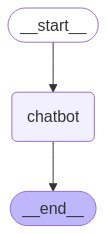

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print(event.values())
    for value in event.values():
      print (value['messages'])
      print("Assistant:", value["messages"].content)

KeyboardInterrupt: Interrupted by user

# Ai Agent with multiple tools

In [ ]:
!pip install arxiv wikipedia

In [ ]:
# working with tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(arxiv_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki_tool.invoke("who is ishowspeed")

'Page: IShowSpeed\nSummary: Darren Jason Watkins Jr. (born January 21, 2005), known online as IShowSpeed or simply Speed, is an American YouTuber and online streamer. He is known for the dramatic and energetic behavior showcased in his variety live streams, as well as his IRL streams in worldwide loca'

In [ ]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [ ]:
tools=[wiki_tool]

In [ ]:
## Langgraph Application
class State(TypedDict):
  messages:Annotated[list,add_messages]


In [ ]:
from langgraph.graph import START,END, StateGraph
graph_builder=StateGraph(State)


In [ ]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key, model_name="qwen-2.5-coder-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d34d4f804d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d34d5343150>, model_name='qwen-2.5-coder-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
## creating the chatbot
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition

graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools",chatbot)
graph_builder.add_edge(chatbot,END)

In [ ]:
graph=graph_builder.compile()

In [ ]:
from IPython.display Import Image, display

diaplay(Image(graph.get_graph().draw-mermaid_png))

In [ ]:
user_input="HI! my name is Kirtan"

events=graph.stream(
    {"messages": [("user",user_input)]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()